In [68]:
import re 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch


In [4]:

if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
!pip install transformers

In [6]:
csv_path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
df =  pd.read_csv(csv_path, encoding="ISO-8859-1", header=None , names=['label', 'ids', 'data', 'flag' , 'user','sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 1,600,000



,label,ids,data,flag,user,sentence
691010,0,2252143984,Sat Jun 20 05:34:00 PDT 2009,NO_QUERY,invention13,i just woke up im so tired i dont want to work...
561148,0,2205352627,Wed Jun 17 04:33:07 PDT 2009,NO_QUERY,simileft,@DEELAMI i wasnt too pleased with the matthew ...
820243,4,1553648559,Sat Apr 18 14:50:10 PDT 2009,NO_QUERY,PaigeSTARR,@dougiemcfly hey dougie! u alright? howz it go...
651306,0,2237849925,Fri Jun 19 06:27:18 PDT 2009,NO_QUERY,thefloatingfrog,@eatsoupandroll I've still never played guitar...
1403084,4,2054813765,Sat Jun 06 08:08:06 PDT 2009,NO_QUERY,94914dianaa,happy bday amy...where every you are
985807,4,1834509506,Mon May 18 03:12:25 PDT 2009,NO_QUERY,volandovoy,.....listening to Coldplay
808011,4,1469110760,Tue Apr 07 05:14:43 PDT 2009,NO_QUERY,teleken,Free indie label sampler records at Amazon? Y...
494916,0,2185069930,Mon Jun 15 16:50:23 PDT 2009,NO_QUERY,jessicaclaire11,yeah just found out i have to work on saturday.
516785,0,2191154958,Tue Jun 16 04:38:58 PDT 2009,NO_QUERY,simplychrissie,@Rix_ie I don't see any.
1481429,4,2067069201,Sun Jun 07 11:41:29 PDT 2009,NO_QUERY,dimabm,@kmbuck hahaha noo silly! radiohead house of c...


In [7]:
df = df[['label' ,'sentence']]
df['label'] = df['label'].replace({4: 1} )
df

,label,sentence
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    800000
1    800000
Name: count, dtype: int64


In [9]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"


def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [10]:
df['preprocessing_sentence'] = df['sentence'].apply(preprocess_apply)
df

,label,sentence,preprocessing_sentence
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- aww, that's a bummer. you shoulda got dav..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,just woke up. having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdb.com - very cool to hear old walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover? ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of all time!! tu...


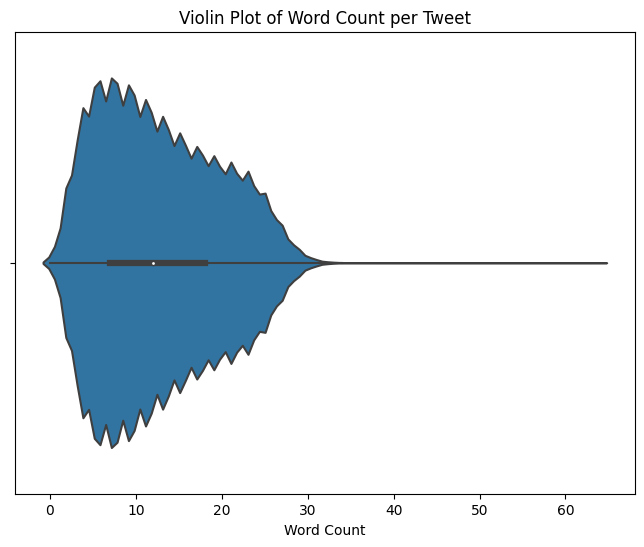

In [11]:
df['word_count'] = df['preprocessing_sentence'].apply(lambda x: len(str(x).split()))

# Calculate the statistics
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['word_count'])
plt.title('Violin Plot of Word Count per Tweet')
plt.xlabel('Word Count')
plt.show()

In [12]:
df

,label,sentence,preprocessing_sentence,word_count
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- aww, that's a bummer. you shoulda got dav...",17
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,21
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...,17
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,10
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",20
...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,just woke up. having no school is the best fee...,11
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdb.com - very cool to hear old walt interv...,10
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover? ask me f...,11
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of all time!! tu...,12


In [13]:
sentences = df.preprocessing_sentence.values
labels = df.label.values

In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:    - aww, that's a bummer.  you shoulda got david carr of third day to do it. ;d
Tokenized:  ['-', 'aw', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer', '.', 'you', 'should', '##a', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']
Token IDs:  [1011, 22091, 2860, 1010, 2008, 1005, 1055, 1037, 26352, 5017, 1012, 2017, 2323, 2050, 2288, 2585, 12385, 1997, 2353, 2154, 2000, 2079, 2009, 1012, 1025, 1040]


In [14]:
max_len = 0
total_len = 0

for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    total_len += len(input_ids)

average_len = total_len / len(sentences)

print('Max sentence length:', max_len)
print('Average sentence length:', average_len)

Max sentence length: 230
Average sentence length: 19.43914


In [16]:
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:    - aww, that's a bummer.  you shoulda got david carr of third day to do it. ;d
Token IDs: tensor([  101,  1011, 22091,  2860,  1010,  2008,  1005,  1055,  1037, 26352,
         5017,  1012,  2017,  2323,  2050,  2288,  2585, 12385,  1997,  2353,
         2154,  2000,  2079,  2009,  1012,  1025,  1040,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [44]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Define split sizes
train_size = int(0.9 * len(dataset)) 
val_size = int(0.07 * len(dataset))    
test_size = len(dataset) - train_size - val_size  



train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Output the sizes of each dataset
print(f'{train_size:,} training samples')
print(f'{val_size:,} validation samples')
print(f'{test_size:,} test samples')


1,440,000 training samples
112,000 validation samples
48,000 test samples


In [45]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 128


train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )


validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=batch_size 
)

In [46]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, logging
logging.set_verbosity_error()


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [47]:
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )



epochs = 2
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_epoch(model, train_dataloader, optimizer, scheduler, device):


    model.train()


    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()

        # forward pass
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        #  backward pass 
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        if (step + 1) % 1000 == 0:
            print(f"Batch {step + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    
    return avg_train_loss

def validate_epoch(model, validation_dataloader, device):

    model.eval()


    total_eval_accuracy = 0
    total_eval_loss = 0


    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    return avg_val_loss, avg_val_accuracy


def save_best_model(model, output_dir, best_val_loss, avg_val_loss):

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        print(f"  New best validation loss: {best_val_loss:.2f}. Saving model...")
        # Save the model and tokenizer
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir) 
    return best_val_loss

## Model Training

In [49]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs, device, output_dir):
    training_stats = []
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity

    for epoch_i in range(epochs):
        print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
        print("Training...")

        avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        print(f"\n  Average training loss: {avg_train_loss:.2f}")

        print("\nRunning Validation...")
        avg_val_loss, avg_val_accuracy = validate_epoch(model, validation_dataloader, device)
        print(f"  Accuracy: {avg_val_accuracy:.2f}")
        print(f"  Validation Loss: {avg_val_loss:.2f}")

        # Record statistics for this epoch
        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        })


        best_val_loss = save_best_model(model, output_dir, best_val_loss, avg_val_loss)

    print("\nTraining complete!")
    return training_stats


In [50]:
output_dir = '/kaggle/working/best_model_save/'
training_stats = train_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs, device, output_dir)


======== Epoch 1 / 2 ========
Training...
Batch 1000/11250: Loss = 0.3659
Batch 2000/11250: Loss = 0.2488
Batch 3000/11250: Loss = 0.3769
Batch 4000/11250: Loss = 0.3911
Batch 5000/11250: Loss = 0.2878
Batch 6000/11250: Loss = 0.3020
Batch 7000/11250: Loss = 0.2592
Batch 8000/11250: Loss = 0.3364
Batch 9000/11250: Loss = 0.3192
Batch 10000/11250: Loss = 0.2441
Batch 11000/11250: Loss = 0.3902

  Average training loss: 0.33

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.30
  New best validation loss: 0.30. Saving model...

======== Epoch 2 / 2 ========
Training...
Batch 1000/11250: Loss = 0.2495
Batch 2000/11250: Loss = 0.2563
Batch 3000/11250: Loss = 0.2376
Batch 4000/11250: Loss = 0.2947
Batch 5000/11250: Loss = 0.1883
Batch 6000/11250: Loss = 0.2119
Batch 7000/11250: Loss = 0.3268
Batch 8000/11250: Loss = 0.2519
Batch 9000/11250: Loss = 0.2854
Batch 10000/11250: Loss = 0.3054
Batch 11000/11250: Loss = 0.2147

  Average training loss: 0.27

Running Validation...
  Accur

## Evaluate on the test set


In [51]:
def predict_and_evaluate(model, test_dataloader, device):

    model.eval()

    total_test_loss = 0
    total_test_accuracy = 0
    predictions = []
    true_labels = []


    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)


            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            loss = outputs.loss
            logits = outputs.logits

            total_test_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()


            total_test_accuracy += flat_accuracy(logits, label_ids)


            pred_flat = np.argmax(logits, axis=1).flatten()
            predictions.extend(pred_flat)
            true_labels.extend(label_ids.flatten())

    # Calculate average loss and accuracy
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)

    return predictions, true_labels, avg_test_loss, avg_test_accuracy


## Load Best Model 

In [52]:

my_model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)


my_model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [53]:
# Evaluate on the test set
predictions, true_labels, test_loss, test_accuracy = predict_and_evaluate(my_model, test_dataloader, device)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

Test Accuracy: 0.88
Test Loss: 0.30


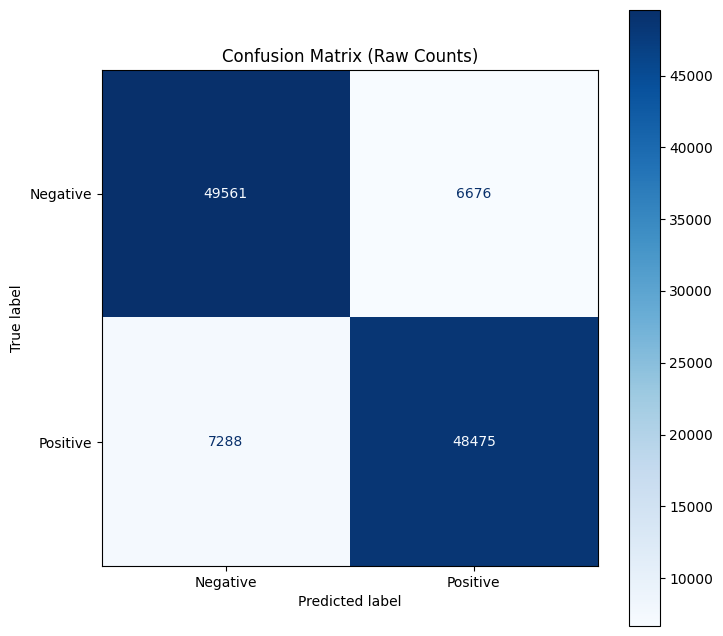

Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.88     56237
    Positive       0.88      0.87      0.87     55763

    accuracy                           0.88    112000
   macro avg       0.88      0.88      0.88    112000
weighted avg       0.88      0.88      0.88    112000



In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(predictions, true_labels, class_names):

    cm = confusion_matrix(true_labels, predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap='Blues', ax=ax, values_format='d')  # 'd' for displaying raw counts
    plt.title("Confusion Matrix (Raw Counts)")
    plt.show()

    report = classification_report(true_labels, predictions, target_names=class_names)
    print("Classification Report:\n")
    print(report)

class_names = ['Negative', 'Positive']  

plot_confusion_matrix(predictions, true_labels, class_names)


In [69]:

def process_and_predict_sentence(sentence, model, tokenizer, device='cuda'):

    encoded_dict = tokenizer.encode_plus(
        sentence,                     
        add_special_tokens=True,     
        max_length=64,                
        pad_to_max_length=True,      
        truncation=True,              
        return_attention_mask=True,   
        return_tensors='pt'           
    )


    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)


    model.eval()


    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)



    return probabilities


## Test The Model

In [66]:
test_sentence = "The movie was fantastic!"
prob = process_and_predict_sentence(test_sentence, model, tokenizer)

prob

tensor([[0.0013, 0.9987]], device='cuda:0')

- **Probability of Negative Class: 0.0013 (or 0.13%)**
- **Probability of Positive Class: 0.9987 (or 99.87%)**

In [64]:
test_sentence = "I am feeling sad today."
prob = process_and_predict_sentence(test_sentence, model, tokenizer)

prob

tensor([[0.9986, 0.0014]], device='cuda:0')

- **Probability of Negative Class: 0.998 (or 99.8%)**
- **Probability of Positive Class: 0.0014 (or 0.14%)**